In [206]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [15]:
BALANCED_DATA_PATH = "./data/earthquake_alert_balanced_dataset.csv"
UNBALANCED_DATA_PATH = "./data/earthquake_data.csv"

In [ ]:
balanced_data = pd.read_csv(BALANCED_DATA_PATH)
unbalanced_data = pd.read_csv(UNBALANCED_DATA_PATH)

In [44]:
balanced_counts = balanced_data["alert"].value_counts(normalize=True) * 100
unbalanced_counts = unbalanced_data["alert"].value_counts(normalize=True) * 100

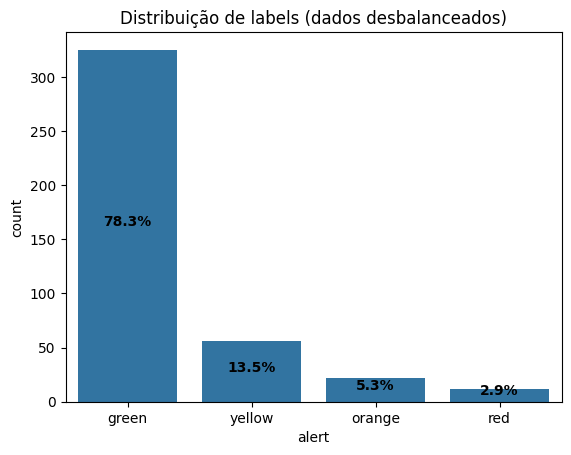

In [48]:
sns.countplot(x="alert", data=unbalanced_data)

for i, v in enumerate(unbalanced_counts):
    plt.text(i, unbalanced_data["alert"].value_counts().iloc[i] / 2, f"{v:.1f}%", color='black', ha='center', fontweight='bold')

plt.title("Distribuição de labels (dados desbalanceados)")
plt.show()

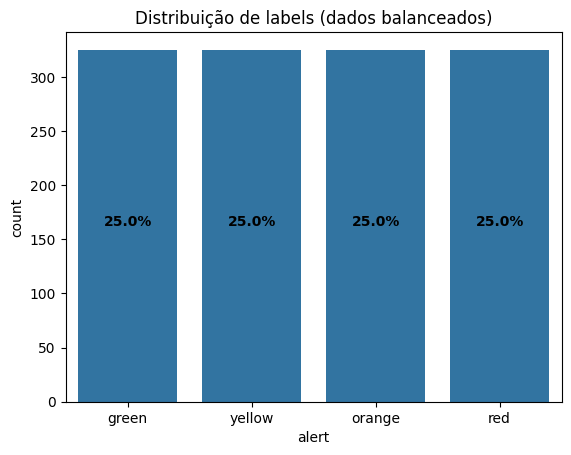

In [52]:
sns.countplot(x="alert", data=balanced_data)

for i, v in enumerate(balanced_counts):
    plt.text(i, balanced_data["alert"].value_counts().iloc[i] / 2, f"{v:.1f}%", color='black', ha='center', fontweight='bold')

plt.title("Distribuição de labels (dados balanceados)")
plt.show()

### Pré-processamento

One-hot Encoding da coluna de labels e padronização com *z-score* das outras colunas. Foi usado esse método de normalização dos dados numéricos pois eles servirão de entrada para o *Multi-Layer Perceptron* (MLP).

In [83]:
df = balanced_data.copy()
encoded = pd.get_dummies(df["alert"], prefix="alert", dtype=int)
df = df.drop(columns=["alert"])
df = pd.concat([df, encoded], axis=1)

In [93]:
df["z_magnitude"] = df["magnitude"].apply(lambda x: (x - df["magnitude"].mean()) / df["magnitude"].std())
df["z_depth"] = df["depth"].apply(lambda x: (x - df["depth"].mean()) / df["depth"].std())
df["z_cdi"] = df["cdi"].apply(lambda x: (x - df["cdi"].mean()) / df["cdi"].std())
df["z_mmi"] = df["mmi"].apply(lambda x: (x - df["mmi"].mean()) / df["mmi"].std())
df["z_sig"] = df["sig"].apply(lambda x: (x - df["sig"].mean()) / df["sig"].std())

Embaralhando as amostras para evitar overfitting por enviesamento.

In [121]:
X, y = df[["z_magnitude", "z_depth", "z_cdi", "z_mmi", "z_sig"]], df[["alert_green", "alert_orange", "alert_red", "alert_yellow"]]
X, y = shuffle(X, y, random_state=42)

In [122]:
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

### MLP

Divisão em treinamento, teste e validação (70/15/15) usando `random_state=42`.

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [174]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [224]:
clf = MLPClassifier(hidden_layer_sizes=(16,), max_iter=1000, random_state=42, learning_rate_init=0.01, batch_size=100, solver="adam", warm_start=True)

In [225]:
train_accuracy = []
test_accuracy = []

In [ ]:
for i in range(1000):  # número de épocas
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_train_pred))
    test_accuracy.append(accuracy_score(y_test, y_val_pred))

In [231]:
train_accuracy = np.array(train_accuracy)
test_accuracy = np.array(test_accuracy)

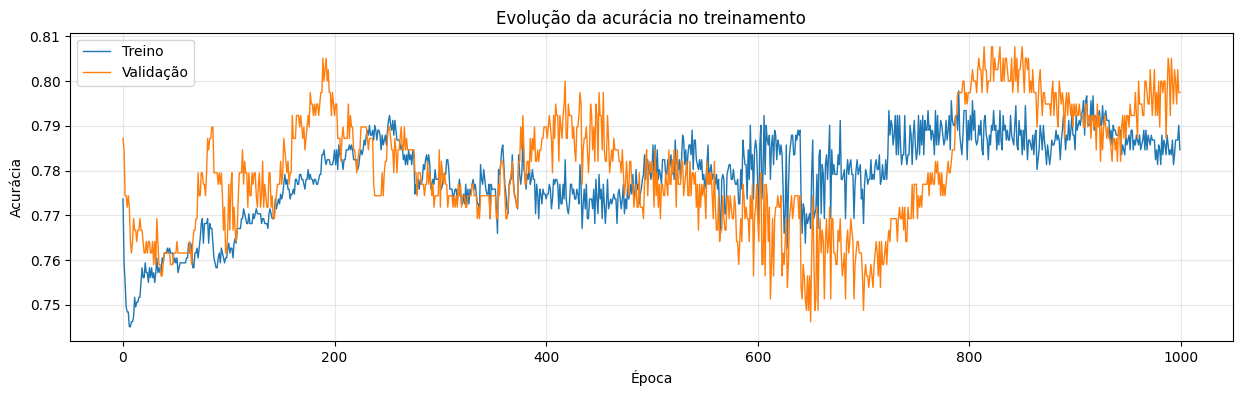

In [245]:
plt.figure(figsize=(15, 4))
plt.plot(train_accuracy, label='Treino', linewidth=1)
plt.plot(test_accuracy, label='Validação', linewidth=1)
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.title("Evolução da acurácia no treinamento")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


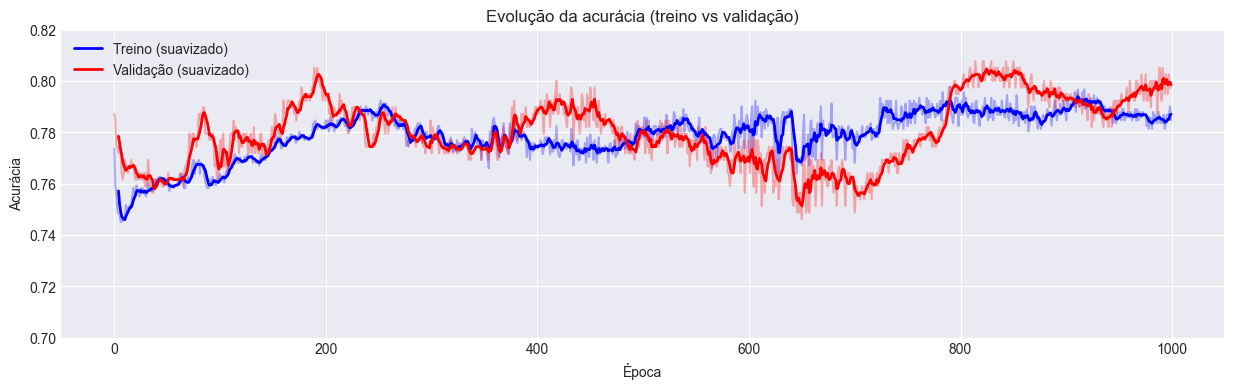

In [256]:
plt.style.use('seaborn-v0_8-darkgrid')

train_smooth = pd.Series(train_accuracy).rolling(5).mean()
test_smooth = pd.Series(test_accuracy).rolling(5).mean()

plt.figure(figsize=(15, 4))

plt.plot(train_accuracy, 'b-', alpha=0.3)
plt.plot(test_accuracy, 'r-', alpha=0.3)

plt.plot(train_smooth, 'b', linewidth=2, label='Treino (suavizado)')
plt.plot(test_smooth, 'r', linewidth=2, label='Validação (suavizado)')

plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.title("Evolução da acurácia (treino vs validação)")
plt.legend()
plt.ylim(0.7, 0.82)
plt.show()